In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, roc_curve, auc
import os
import sys
from tabulate import tabulate
from functools import reduce
from pathlib import Path

In [ ]:
# reading main config file
config = utils.read_config()

system = 2 # 1 or 2
if system == 1:
    PATH = config["Source"]["paths"]["source_path_system_1"]
elif system == 2:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    PATH = config["Source"]["paths"]["source_path_system_2"]
else:
    PATH = ""
    print("Invalid system")

In [5]:
def calculate_metrics(pred_prob, GT):
    fpr, tpr, thresholds = roc_curve(GT, pred_prob)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    pred_labels = (pred_prob >= optimal_threshold).astype(int)
    #print("prediction: ", pred_labels)
    #print("GT: ", GT)

    # Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
    TP = ((pred_labels == 1) & (GT == 1)).sum()
    TN = ((pred_labels == 0) & (GT == 0)).sum()
    FP = ((pred_labels == 1) & (GT == 0)).sum()
    FN = ((pred_labels == 0) & (GT == 1)).sum()
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    specificity = TN / (TN + FP)
    auc_score = auc(fpr, tpr)

    results = [
        ["True Positives (TP)", TP],
        ["True Negatives (TN)", TN],
        ["False Positives (FP)", FP],
        ["False Negatives (FN)", FN],
        ["Sensitivity", sensitivity],
        ["Precision", precision],
        ["Specificity", specificity],
        ["AUC", auc_score]
    ]
    # Print results in tabular form
    print(tabulate(results, headers=["Metric", "Value"], tablefmt="fancy_grid"))

    return auc

In [ ]:
def best_model_selection_from_fold(system, type, category, experiment_number, fold_number):
    repls = ("Network_Weights/best_model", "Metrics/epoch"), ("pth.tar", "csv")
    
    if type == "regression":
        path = config["Source"]["paths"][f"source_path_system_{system}"] + config["regression_path"] + f"/Experiment_{experiment_number}/CV_{fold_number}/Network_Weights/"
    else:
        path = config["Source"]["paths"][f"source_path_system_{system}"] + config["classification_path"] + f"/{category}/Experiment_{experiment_number}/CV_{fold_number}/Network_Weights/"
    
    model_files = []
    for dirs, subdirs, files in os.walk(path):
        for file in files:
            file_path = str(os.path.join(dirs, file))
            file_path = file_path.replace('\\','/')
            model_files.append(file_path)

    model_dict = dict()

          
    if type=="regression":   
        best_metric = 100000000
    else:
        best_metric = -1

    for model_path in model_files:
        metric_path = reduce(lambda a, kv: a.replace(*kv), repls, model_path)
        metric_data = pd.read_csv(metric_path)

        if type=="regression":   
            metric = mean_absolute_error(metric_data["GT"], metric_data["prediction (age)"])
            if metric < best_metric:
                best_metric = metric    
        else:
            metric = cohen_kappa_score(metric_data["prediction"], metric_data["GT"])
            if metric > best_metric:
                best_metric = metric   
        
        model_dict[metric] = model_path
          
    #print(model_dict)
    best_model_path = model_dict[best_metric]
    epoch_to_continue = best_model_path.split("_")[-1].split(".")[0]
    return best_model_path, epoch_to_continue

In [ ]:
def evaluate_best_models_all_folds(system, type, category, experiment_number, folds_list):
    repls = ("Network_Weights/best_model", "Metrics/epoch"), ("pth.tar", "csv")

    metric_data_list = []
    for fold_number in folds_list:
        best_model_path, _ = best_model_selection_from_fold(system, type, category, experiment_number, fold_number)
        best_metric_path = reduce(lambda a, kv: a.replace(*kv), repls, best_model_path)
        print(best_metric_path)
        metric_data = pd.read_csv(best_metric_path)
        metric_data_list.append(metric_data)

    all_metric_df = pd.concat(metric_data_list)

    if type=="regression":        
        metric_r_squared = r2_score(all_metric_df["GT"], all_metric_df["prediction (age)"])
        metric_mae = mean_absolute_error(all_metric_df["GT"], all_metric_df["prediction (age)"])
        metrics = {"metric_mae":metric_mae, "metric_r_squared":metric_r_squared}
        return metrics
    else:
        c_k_score = cohen_kappa_score(all_metric_df["prediction"], all_metric_df["GT"])
        idx_classes = ["C81_GT", "C83_GT", "Others_GT"]
        col_classes = ["C81_Pred", "C83_Pred", "Others_Pred"]
        confusion_matrix_df = pd.DataFrame(confusion_matrix(all_metric_df["GT"], all_metric_df["prediction"]), columns=col_classes, index=idx_classes)
        metrics = {"c_k_score":c_k_score, "confusion_matrix":confusion_matrix_df}
        return metrics

### For regression

In [10]:
metrics = evaluate_best_models_all_folds(system=2, type="regression", category=None, experiment_number=2, folds_list=list(range(10)))
metrics

In [ ]:
plt.scatter(data['GT'], data["prediction (age)"])

### For classification

In [11]:
metrics = evaluate_best_models_all_folds(system=1, type="classification", category="Diagnosis", experiment_number=1, folds_list=list(range(10)))
metrics

7.451295360655737
0.46299463012746134


In [ ]:
confusion_matrix_df = metrics["confusion_matrix"]
pred_class= list(confusion_matrix_df.columns)
GT_class= list(confusion_matrix_df.index)
print(pred_class, GT_class)
metrics["confusion_matrix"]

In [ ]:
# Test Specifity calculation
FP = np.sum(np.array(metrics["confusion_matrix"].loc[["C83_GT", "Others_GT"], ["C81_Pred"]])) #+ metrics["confusion_matrix"].loc["Others_GT", :].sum()
TN = np.sum(np.array(metrics["confusion_matrix"].loc[["C83_GT", "Others_GT"], ["C83_Pred", "Others_Pred"]]))
specificity = TN/(TN+FP)
FP, TN, specificity

In [ ]:
specificity = []
for cls in GT_class:
    cls_orig = cls.split('_')[0]
    FP = np.sum(np.array(metrics["confusion_matrix"].loc[[i for i in GT_class if i!=cls], [cls_orig + "_Pred"]]))
    TN = np.sum(np.array(metrics["confusion_matrix"].loc[[i for i in GT_class if i!=cls], [i for i in pred_class if i!=cls_orig + "_Pred"]]))
    specificity.append(TN/(TN+FP))
specificity

<Axes: >

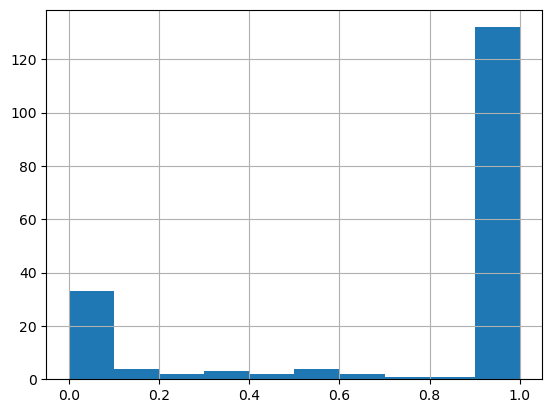

In [12]:
data["prediction_probability (diagnosis)"].hist()

### Check reshaped projections

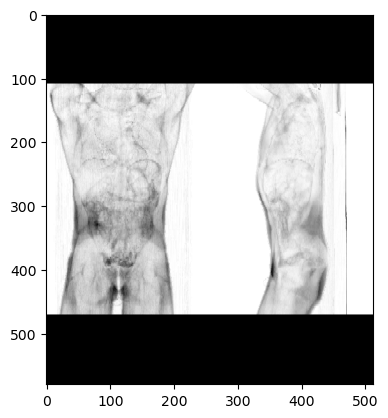

In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
image = np.load("/media/andres/T7 Shield1/UCAN_project/collages/reshaped_collages/lpr385705046400/20140313/CT_adipose.npy")
plt.imshow(image, cmap="gray")
plt.show()

In [10]:
path = "/media/andres/T7 Shield1/UCAN_project/collages/reshaped_collages/npr113096472044/20110318/"
lst1 = ["SUV_", "CT_"]
lst2 = ["MIP.npy","bone.npy","lean.npy","adipose.npy","air.npy"]

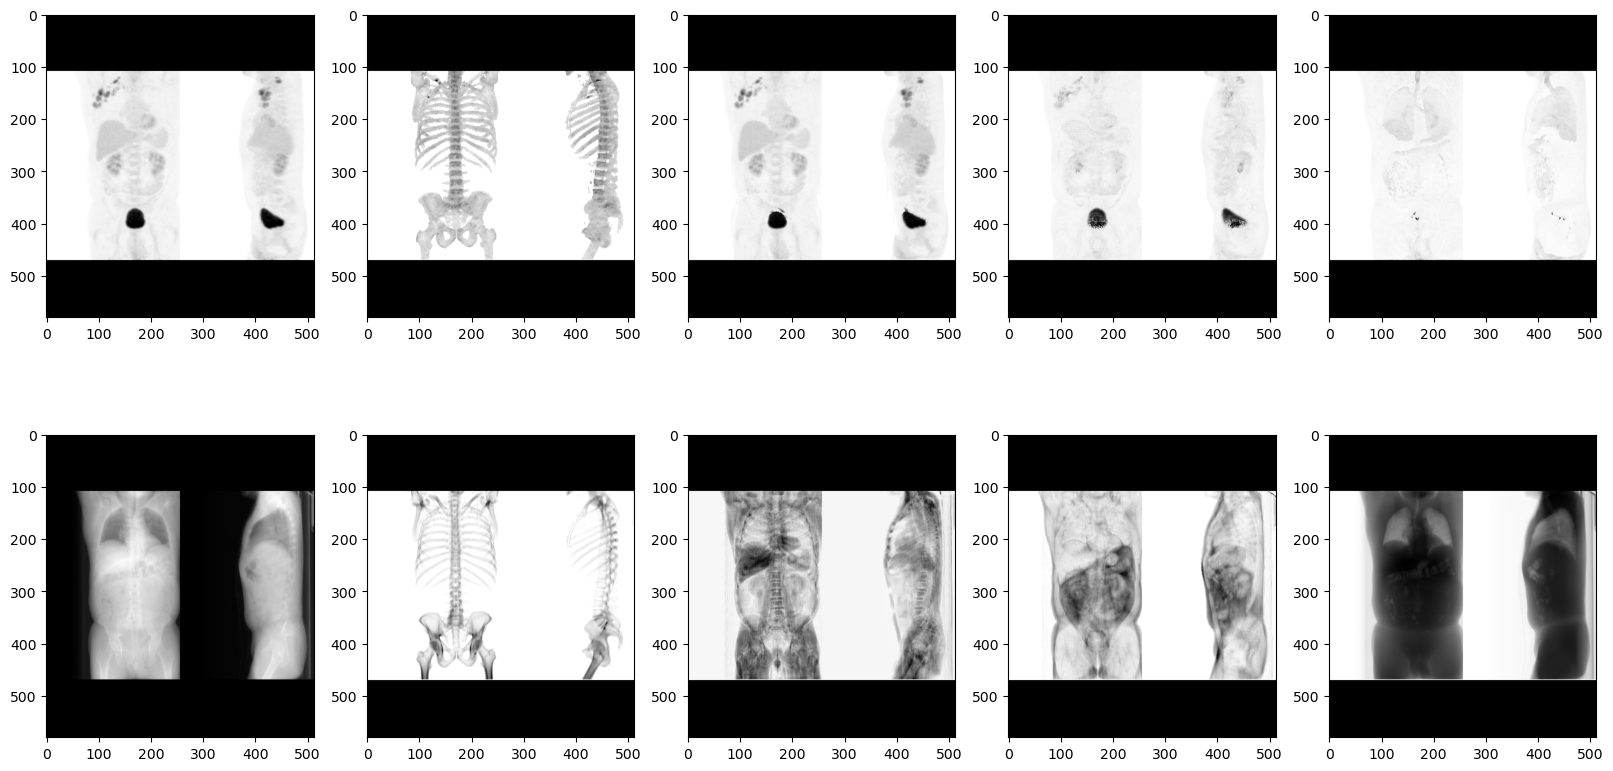

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,10))

cv=0
for i in range(2):
    for j in range(5):
        img = np.load(path + lst1[i] + lst2[j])
        axs[i, j].imshow(img,cmap="gray")
        cv += 1
plt.show()

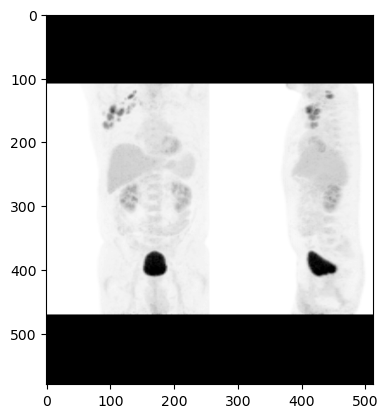

In [12]:
img = "/media/andres/T7 Shield1/UCAN_project/collages/reshaped_collages/npr113096472044/20110318/SUV_MIP.npy"
image_max = np.load(img)
plt.imshow(image_max, cmap="gray")
plt.show()

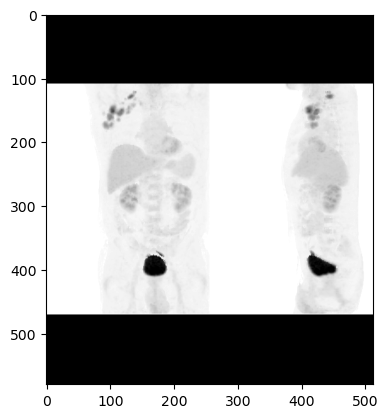

In [13]:
img = "/media/andres/T7 Shield1/UCAN_project/collages/reshaped_collages/npr113096472044/20110318/SUV_lean.npy"
image_mean = np.load(img)
plt.imshow(image_mean, cmap="gray")
plt.show()

In [14]:
(image_max == image_mean).all()

False

In [ ]:
/media/andres/T7 Shield1/UCAN_project/Dataframe
/home/ashish/Ashish/UCAN/Dataframe